# Predicting Severe National Power Outage Causes

**Benjamin Chen and Max Wei**

## Summary of Findings


### Introduction

This project uses data from [this](https://engineering.purdue.edu/LASCI/research-data/outages/outagerisks) public dataset from Purdue University that documents major power outages witnessed within U.S. States withn the time period January 2000 - July 2016. Major power outages refer to those that impacted more than 50,000 customers or caused an unplanned load loss of 300 MW or more as defined by the Department of Energy. The dataset also contains geographic data, regional climate data, and land-use characteristics. A summary of the data contained within can be found [here](https://www.sciencedirect.com/science/article/pii/S2352340918307182). 

We previously conducted a detailed analysis exploring the nuances of certain power outage cause categories, which resulted in us learning that each power outage cause has a few distinct features that differentiate them from each other. Intrigued by these findings, we were left with the question 'Do these distinct qualities of cause categories represent a large enough deliniation to predict the cause of a power outage using such features?' This is the prediction problem we are attempting to address; by looking at various features such as outage duration or customers affected, is it possible to determine what caused these outages? The variable we'll be predicting is 'cause.category', the general category that caused a specific power outage, selected from 7 possible categories total. The main estimator we'll be applying is accuracy, mainly because the stakes of our model are not very high, it is not life threatening in anyway if the cause category is incorrectly predicted. As such, we are not too considered about the recall nor the precision as the prevalence of false negative and false positive results are not a large concern.

### Data Cleaning
We posit that the data appears to be generated both computationally and hand entered. We believe a large portion to be computer processed due to the uniformity of the data in terms of certain columns such as the start and end time as well as state names or climate region. There were no obvious human errors in these columns as there was a lack of manual nans such as using '-' as a categorical placeholder or -9999 as a numerical placeholder. However, in some other columns there were clerical mistakes that hint towards human input. For example, in 'cause.category.detail', categories that detailed the same specific cause had some variable forms such as the perplexing existence of both 'coal' and ' coal'(with a space in front of it) that clearly mean the same thing, but were entered inconsistently. Some data columns also seem unlikely to be able to be computer generated. For example "cause.category.detail"'s data generation process seems to fit more along the lines of a human clerk picking from multiple choice dropdown than computer generation.

The first step of our cleaning started with loading in the data. Since the data comes from an excel spreadsheet, we ignored the first 5 rows and 2 columns, which contained only meta-data that is relevant to the comprehensibility of a spreadsheet, but is irrelevant to a DataFrame. This step also included dropping the first row which contained unit descriptions and the columns 'variables', which in the context of Excel, demarcates the columns of the data and 'obs' which was just a numerical index. After loading in the data, we refactored some information to more accurately represent the meaning of the column. For example, we casted 'month' from a numerical representation to a nominal one because in the context of the dataset, months is more accurately described as a categorical variable, rather than a numerical one. We also reprocessed the columns indicating start day and start time into a single uniform datetime object to clearly demarcate the point of occurrence. Besides this, we verified the integrity of our data by checking the types of each column and ensuring they are appropriate for the data type (for example, years are represents as integers instead of strings or floats).

### Baseline Model
For our baseline model, we chose to use the following features:

1. outage.duration - used as is (numerical data, represents the duration of each outage in minutes)
2. month - OneHotEncoder() (original form was in strings)
3. u.s._state - OneHotEncoder() (original form was in strings)

Most of the features in our dataset were categorical, with the only 2 numerical ones being outage duration and customers affected. We chose the 3 features 'outage.duration', 'month', and 'u.s._state' because we thought that out of all those available, they would be the most informative for our model to predict cause category. From our previous exploration, we know that the numerical column outage duration was closely related to the caues of the power outage. For example, power outages caused by the category "intentional attacks" had the unique property of an extremely low outage duration. This means that certain values of outage duration would strongly suggest certain cause categories, leading us to believe that it's a strong feature to include. Our second feature is "month", which is a categorical column indicating when the outage occurred. From our previous investigation, we noticed that the month an outage occurred in can also indicate the type of power outage. For example, we previously found that public appeal outages only occurred in the summer months (june, july, august). As such, the model can make strong inferences on the cause category based on the month that it occurred in. Lastly, we included "u.s._state", a categorical column that indicates the geographic location of the power outage. States all have unique qualities that define the type of power outages that occur. This encapsulates weather patterns, some hint of government policy, and general social behavior. For example, public appeal outages are extremely common only in specific states such as California.

These 3 features culminate to answer the questions that could go into predicting cause category: 
1. How devastating was the power outage?
2. When did it happen?
3. Where did it happen? 
We hope that by providing the data necessary to answer these questions, we can achieve a reasonably good baseline model.

For our classifier we opted to go with a RandomForestClassifier in order to leverage its programmatic "natural selection" for use in our multi-class classification.

Our resulting model achieved a baseline accuracy of about 0.83 on training data and about 0.75 on testing data. This baseline model already seems to perform quite well, however we believe that it can do better. The high accuracy we're achieving may simply be a direct result of our data: most of the power outages consist of severe weather causes (almost 50%), as such, even though our initial accuracy seems quite high, it is deceptively good. A model that simply predicts every outage to be caused by severe weather would already achieve a 50% accuracy. That means that on our testing data, the 75% accuracy could really just mean 100% accuracy on severe weather causes and only 50% on non severe weather causes, making our predictions subpar and limiting its generalizability to future unseen data. In order to make our model have a meaningful output, we need to achieve a higher accuracy.


### Final Model
For our final model, we chose to use the following features:

1. outage.duration - standardized using stdscaler() (converted from numerical data, represents the duration of each outage in minutes)
2. month - OneHotEncoder() (original form was in strings)
3. u.s._state - OneHotEncoder() (original form was in strings)
4. time_of_day - used FunctionTransformer() to convert start time to seconds to indicate time of day
5. percent customers affected - derived from customers affected, represents the proportion of the state's population that were affected by the outage.

For our final model, we included 2 features in the same form from the base model: 'month' and 'u.s._state'. We decided to standardize outage.duration to contextualize the outage durations. Standardizing the values in this case desensitizes the model to raw numerical differences, instead giving a more accurate representation of how extreme or not each outage duration is in relation to each other. On top of these 3 features that were present in the baseline model, we also decided to include the percent customers affected and time of day. Percent customers affected is an engineered feature that represents the proportion of a state's population that was subject to the power outage. We were unsure of how it would help build predictions because we saw from previous work that the number of customers affected did not have a very clear correlation to the cause category. However, after further consideration we believe that it may help indicate certain extreme occurrences such as power outages as a result of natural disasters. Converting it to a percent also increases the generalizability of our model as it can be applied to any power outage data that contains the total population of a state. Time of day is another engineered feature that's derived from 'start time'. it's converted from a datetime instance to an integer representing the number of seconds into the given day when the power outage occurred. We theorize that this feature will help our model because certain cause categories could be subject to a time window. We chose to limit ourselves to these features as we concluded that other features could introduce redundancy, resulting in our model potentially overfitting and becoming less generalizable. We argue that these 5 features are the strongest indicators to be drawn from the dataset for cause category and will yield a reasonable accuracy for predictions.

For our classifier, we opted to stick with the same RandomForestClassifier we chose for our basic model.

This new model achieved a training accuracy of 0.913 and a testing accuracy of 0.822. While this testing accuracy seems quite reasonable, since we are using a RandomForestClassifier, we decided to try and fine tune some hyperparameters. Looking at the documentation we arrived at a conclusion that n_estimators, criterion, and max_depth were a few of the most impactful hyperparameters for our model. So we went ahead and ran cross validation grid search on n_estimators: 0-200, criterion: gini, entropy, and loss_loss, and max_depth: 1-20. As a result, we found the best hyperparameters to be n_estimators: 140, criterion: gini, and max_depth: 16, with a validation accuracy of 0.867. After training this final optimized model with the best hyperparameters we found, we achieved a new training accuracy of 0.986 an a testing accuracy of 0.830. This means that tuning our hyperparameters with GridSearchCV improved our model's overall testing accuracy by a modest 0.008.




### Fairness Analysis

From our EDA, we discovered that a large portion of the outages in our dataset were caused by severe weather. Understanding the major effects hurricanes have on local communities and infrastructure, we postulated that our classification model may be more inclined to predict outages as caused by severe weather. We also noticed that hurricanes, in our dataset, only occured between the months July to October. This led us to investigate the difference in performance our model has on outages that occured during hurricane months and outages that occured in non-hurricane months. To do this, we ran a permutation test with a significance level of 0.05 on the difference in accuracy between predictions made on hurricane month outages and non-hurricane month outages.

> Null Hypothesis: Our model is fair. Its accuracy for hurricane season outages and non-hurricane season outages are roughly   
the same, and any differences are due to random chance.
<br>
<br>Alternative Hypothesis: Our model is unfair. Its accuracy for hurricane season outages is higher than its accuracy for non-hurricane season outages.

Our resulting p-value was 0.585, leading us to fail to reject the null hypothesis. We concluded that our model performance was fair, at least between hurricane and non-hurricane month outages.

## Code

Importing all packages we need to work with data.

In [548]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures
import calendar

import warnings
warnings.filterwarnings('ignore')

importing all sklearn functions necessary to build the model.

In [549]:
from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

## Data Cleaning

Our first step is to read in our data from the excel sheet. Using argument passing, we skip by empty cells in the excel that are meant for formatting. We then dropped the first row that indicated units of each category and the columns that were irrelevant (obs is a numerical index and variables indicates in excel the columns of the table).

In [550]:
#read in excel, skip formatting, drop units row, drop obs col
outages = (pd.read_excel(os.path.join('data','outage.xlsx'), skiprows = 5).drop(0).drop(columns = ['variables', 'OBS']))

In order to make our data more usable, some data cleaning and refactoring was required. The original dataframe that's read in from the excel had 2 separate columns to indicate when power outages occurred and ended - the start/restoration date, which only included the year-month-day, and the start/restoration time, which only included the hour:minute:second that it started/ended. These columns were respectively condensed into a single column 'start'/'end' which indicated in a single pd.datetime object the aforementioned information. On top of this, certain time data columns were reformatted to appropriately indicate their use. Month and year were both translated from a numerical representation to a categorical one (i.e. from number to name). Though they can be represented as numbers, in the context of our analysis they are used as categorical variables to deliniate power outages that occur at different time periods, thus making it more appropriate for them to be nominally represented. 

In [551]:
def format_time(df):
    """
    function to reformat time input for start and restoration date into a datetime structure. 
    Also refactors Months into names instead of numerical representation and years into integers.
    Also adds a season column based on the month of the outage.

    input:
        df(pd.df): dataframe to perform operations on.

    returns:
        copy of dataframe where the used columns are dropped, new columns 'START' and 'END' are 
        inputted in their place, month data and years is refactored, and seasons are added.
    """
    seasons_dict = {'Jan':'winter','Feb':'winter','Mar':'spring','Apr':'spring','May':'spring','Jun':'summer','Jul':'summer','Aug':'summer','Sep':'autumn','Oct':'autumn','Nov':'autumn','Dec': 'winter'}
    outages = df.copy()
    # REFORMAT TIME DATA
    outages['START'] = pd.to_datetime(outages['OUTAGE.START.DATE'].astype(str).str[:-8] + outages['OUTAGE.START.TIME'].astype(str))
    outages['END'] = pd.to_datetime(outages['OUTAGE.RESTORATION.DATE'].astype(str).str[:-8] + outages['OUTAGE.RESTORATION.TIME'].astype(str))
    outages = outages.drop(columns = ['OUTAGE.START.DATE', 'OUTAGE.START.TIME', 'OUTAGE.RESTORATION.DATE', 'OUTAGE.RESTORATION.TIME'])
    # REFORMAT MONTH FROM INT TO STR
    outages['MONTH'] = pd.DataFrame(outages['MONTH']).applymap(lambda x: calendar.month_abbr[int(x)], na_action = 'ignore')
    # CAST YEAR TO INT COL
    outages['YEAR'] = outages['YEAR'].astype(int)
    # CREATE SEASONS COL
    outages['SEASON'] = outages['MONTH'].replace(seasons_dict)
    return outages
    
outages_time = format_time(outages)

During our exploration, we discovered that certain columns containing string data had clerical errors such as leading and trailing white spaces as well as inconsistent character case. In order to account for this, we converted the contents of all string data columns into lower case and applied .strip() to remove unexpected white spaces. After these operations, the string data types should be consistent. We also converted column names to lower case for ease of query. 

In [552]:
def clean_strs(df):
    """
    function to reformat string data. Relevant strings are stripped and lower-cased.

    input:
        df(pd.df): dataframe to perform operations on.

    returns:
        copy of dataframe where string data is reformatted and column names are lowered.
    """
    outages = df.copy()
    outages.columns = outages.columns.str.lower()
    outages[outages.convert_dtypes().select_dtypes('string').columns] = outages[outages.convert_dtypes().select_dtypes('string').columns].applymap(str.lower, na_action = 'ignore')
    outages[outages.convert_dtypes().select_dtypes('string').columns] = outages[outages.convert_dtypes().select_dtypes('string').columns].applymap(str.strip, na_action = 'ignore')
    return outages[['year', 'month', 'u.s._state', 'climate.category', 'cause.category', 'cause.category.detail',
                    'hurricane.names', 'outage.duration', 'start', 'end', 'customers.affected', 'population']]

outages_clean = clean_strs(outages_time)

In [553]:
outages_clean.head().drop('cause.category', axis=1)

,year,month,u.s._state,climate.category,cause.category.detail,hurricane.names,outage.duration,start,end,customers.affected,population
1,2011,jul,minnesota,normal,NaN,NaN,3060,2011-07-01 17:00:00,2011-07-03 20:00:00,70000.0,5348119.0
2,2014,may,minnesota,normal,vandalism,NaN,1,2014-05-11 18:38:00,2014-05-11 18:39:00,NaN,5457125.0
3,2010,oct,minnesota,cold,heavy wind,NaN,3000,2010-10-26 20:00:00,2010-10-28 22:00:00,70000.0,5310903.0
4,2012,jun,minnesota,normal,thunderstorm,NaN,2550,2012-06-19 04:30:00,2012-06-20 23:00:00,68200.0,5380443.0
5,2015,jul,minnesota,warm,NaN,NaN,1740,2015-07-18 02:00:00,2015-07-19 07:00:00,250000.0,5489594.0


In order for us to build a model using SKLearn, we had to deal with missingness either by dropping the datapoints that had missing values or imputing the missing values. Within the columns that we selected for, only 2 columns had any missingness at all: "outage.duration" and "customers.affected". Outage duration only had 9 missing values, which is a number small enough that we are comfortable with simply dropping those data entries. The second column that had missingness was customers affected which had 443 missing entries. This number is noticeably larger and consisted of almost 30% of our data. We considered imputing these entries, but concluded that we were uncomfortable doing so as we could introduce many unintended consequences in doing so. The number of customers affected seemed sporadic and not really tied to any other feature in particular, meaning that it's difficult to conclude a reasonable strategy to impute values. With that in mind, we decided to proceed by dropping them, which left us with about 70% of our original data still intact. This definitely hurts the generalizability of our model, but we felt that imputing the missingness of customers affected could be much more detrimental than simply dropping them.

In [554]:
# Remove missing outage durations that are missing because of a missing start/end time (9 entries)
# Remove missing customer affected data (443 entries)
# remaining data: 1082 / 1534 = ~70% of the original data
outages_clean = outages_clean[~outages_clean['outage.duration'].isna()]
outages_clean = outages_clean[~outages_clean['customers.affected'].isna()]
outages_clean[['customers.affected', 'cause.category', 'outage.duration', 'year','month','u.s._state']].isna().sum()

customers.affected    0
cause.category        0
outage.duration       0
year                  0
month                 0
u.s._state            0
dtype: int64

As can be seen from the result, our data is now clear of missingness. We're ready to begin building a model.

## Tools

In order to make evaluating our future results easier, we wrote a function to calculate the accuracy score of a pipeline on a training and testing data split.

In [555]:
def test_pl(pl, data=outages_clean):
    """
    function to determine the training and testing accuracy of a given model.

    input:
        pl (SKLearn Pipeline): Pipeline to test accuracy on.
        data (dataframe): data to be fed into pipeline. Default value is outages_clean.
    
    returns:
        a Dataframe consisting of the training and testing accuracy of pl on data.
    """
    X_train, X_test, y_train, y_test = train_test_split(data.drop(columns='cause.category'), 
                                                        data['cause.category'], 
                                                        test_size=0.25, random_state=42)
    pl.fit(X_train, y_train)
    return pd.DataFrame([pl.score(X_train, y_train), pl.score(X_test, y_test)], columns=['accuracy'], index=['train','test'])

## Baseline Model

Now, we can begin modeling and evaluating. We selected 3 main features to be considered in our baseline model. The aim was to provide data that could address 3 overarching questions that are integral to predicting the cause category of a power outage.

1. How severe was the outage?
2. When did the outage occur?
3. Where did the outage occur?

These 3 questions were addressed with the 'outage.duration', 'month', and 'u.s._state'. outage duration was used as is, we didn't feel the need to manipulate the data at this stage yet as it came in a numerical form that is acceptable for our pipeline. For month and u.s. state, we one hot encoded them to allow our classifier to process the data. in the cell below, we use a ColumnTransformer to perform the aforementioned operations, dropping the remaining columns.

In [556]:
preproc = ColumnTransformer([('quant', FunctionTransformer(lambda x: x), ['outage.duration']),
                             ('onehots', OneHotEncoder(handle_unknown='ignore'), ['month', 'u.s._state'])]
                           , remainder = 'drop')

Using our ColumnTransformer, we construct a pipeline that first preps the data and then predicts using a randomforestclassifier. We chose a RadomForestClassifier because it seemed to be the most appropriate for the situation where we are performing a multi-class classification. Given the unique property of RandomForestClassifiers to perform progammatic "natural selection" where favorable traits are weighed more heavily in the resulting tree, it seemed as the clear best choice. Also due to the nature of our problem, we opted to use a RandomForestClassifier for both the baseline and the upcoming final model. This allows us to more directly compare the results of the two attempts and see the fruition of our upcoming feature engineering and fine tuning of the model.

In [557]:
pl = Pipeline(steps=[('preproc', preproc), ('clf', RandomForestClassifier(max_depth=10, random_state=42))])
pl;

We evaluate the accuracy of our pipeline by calling the function test_pl() from our Tools section. The result yields a training accuracy of about 0.83 and a testing accuracy of about 0.75. This result seems relatively favorable already, but the high accuracy needs to be taken with a grain of salt due to the nature of our dataset. Almost half the cause categories are severe weather, meaning that even an awful model that just predicts everything to be caused by severe weather would have a 50% accuracy. This means that assuming our model predicted severe weather well, we only had a 50% accuracy on the remaining categories, resulting in the ~75% accuracy on testing data. This result makes it difficult for our base model to be generalized on unseen data, especially if its predictions for non severe weather causes are a literal coinflip. Not exactly the best, but a solid starting point. 

In [558]:
test_pl(pl)

,accuracy
train,0.833333
test,0.746212


## Final Model

Now, we will improve our classification model based on our evaluation of our baseline model. In our improved model we elected to keep the 3 features we considered in our baseline model, but standardize outage.duration in order to desensitive our model to the raw numerical differences between certain outages, to provide a more accurate representation of the outage severity. Furthermore, we chose to engineer two new features: the time of day when the outage occured, and the percent of the state's population affected by the outage. We are choosing to improve time_of_day as a feature, since certain outage causes such as public appeal or intentional attacks may be more likely during certain times of the day than others. Along the same lines, we chose to include percent_customers_affected as certain outage causes may affect more customers than others. For example, one could postulate that a hurricane caused outage may be more severe and affect more customers than one caused by public appeal. Furthermore, electing to convert this data into percent by state helps increase the generalizability of our model, as certain states may just have a higher raw population than others, meaning that any outage would affect more customers.

In [575]:
def percent_affected(df):
    """
    function to convert number of customers affected into percent population affected.
    
    input:
        df(DataFrame): a dataframe containing customers.affected and population data
        
    returns:
        a one column dataframe containing percent population affected
        
    """
    return (df['customers.affected'] / df['population']).to_frame()

In [576]:
def transform_times(df):
    def convert_to_sec(input):
        """
        function to convert a datetime string into seconds.

        input:
            input(datetime string): string to perform operation on (format: DD:DD:DD)
        
        returns:
            the number of seconds translated from the string.
        """
        hour, minute, sec = input.split(':')
        return int(hour)*3600 + int(minute)*60 + int(sec)
    return df.squeeze().dt.time.astype(str).apply(convert_to_sec).to_frame()

In [577]:
preproc = ColumnTransformer([('quant', FunctionTransformer(percent_affected), ['customers.affected', 'population']),
                             ('std_scale', StandardScaler(), ['outage.duration']),
                             ('time_of_day', FunctionTransformer(transform_times), ['start']),
                             ('onehots', OneHotEncoder(handle_unknown='ignore'), ['month','u.s._state'])]
                           , remainder = 'drop')

For our final model classifer, we elected to stick with the RandomForestClassifier, with max depth of 10, that we chose in our baseline model.

In [562]:
pl = Pipeline(steps=[('preproc', preproc), ('clf', RandomForestClassifier(max_depth=10, random_state=42))])
pl;

Once again, we will evaluate our updated model with our test_pl function. Our results this time yeild a training accuracyh of 0.913 and a testing accuracy of 0.822. This is a pretty good improvement of 0.076 testing accuracy over our baseline model. This indicates to us that standardizing outage duration and including time_of_day and percent_customers_affected proved to be good indicators for non-severe weather cause categories. if we hold the same assumption as we did in evaluating our base model where severe weather causes were evaluated correctly (i.e. base 50% accuracy), our final model achieved about a ~64% accuracy on the remaining categories, a marginal improvement over the 50% of the base model. This allows us to more confidently generalize our model to unseen data as its features are now more robust and its accuracy is above a coinflip for non severe weather classifications now.

In [563]:
test_pl(pl)

,accuracy
train,0.912879
test,0.821970


### GridSearch

In order to further optimize our classification model, we run GridSearchCV in order to find good values for our hyperparameters. Here, we elected to focus on the three commonly imporant RandomForest hyperparameters: n_estimators, criterion, and max_depth. For n_estimators we abritrarily choose the range 0-200 in order to encompase most scenarios, while we included all possible options for criterion. For max_depth we chose to limit it from 1-19 in order to reduce our chances of overfitting, since we do not have enough features to really warrant high tree depths.

In [564]:
param_grid = {
    'clf__n_estimators': np.arange(0,200,20),
    'clf__criterion': ['gini', 'entropy', 'log_loss'],
    'clf__max_depth': np.arange(1,20)
}

grid_search = GridSearchCV(estimator = pl, param_grid = param_grid, cv = 5, n_jobs = -1)
X_train, X_test, y_train, y_test = train_test_split(outages_clean.drop(columns='cause.category'), 
                                                    outages_clean['cause.category'], 
                                                    test_size=0.25, random_state=42)
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'clf__criterion': 'gini', 'clf__max_depth': 16, 'clf__n_estimators': 140}

In [565]:
grid_search.best_score_

0.8674388981768969

Looking at our Grid Search results, we see that we found our best hyperparameters to be criterion: gini, max_depth: 16, and n_estimators: 140, with a validation score of 0.867

Finalizing our classification model with these optimized hyperparameters and testing again with our test_pl function, we result with a training accuracy of 0.986 and a testing accuracy of 0.830. This is a modest testing accuracy improvement of 0.008 over our previous model. While fine tuning and optimizing our hyperparameters did improve our testing accuracy, it did not improve our model significantly, so further fine tuning of our hyperparameters would likely not be an efficient use of time.

In [566]:
test_pl(grid_search.best_estimator_)

,accuracy
train,0.986111
test,0.829545


## Fairness Analysis

Seeing that a large portion of our observed outages were caused by severe weather, which include hurricanes, we became curious whether or not hurricane outages were skewing our classification results. Therefore, we decided to investigate the distribution of hurricane outages to see if hurricane outages are associated with specific groups. Here we plot the number of hurricane outages by month.

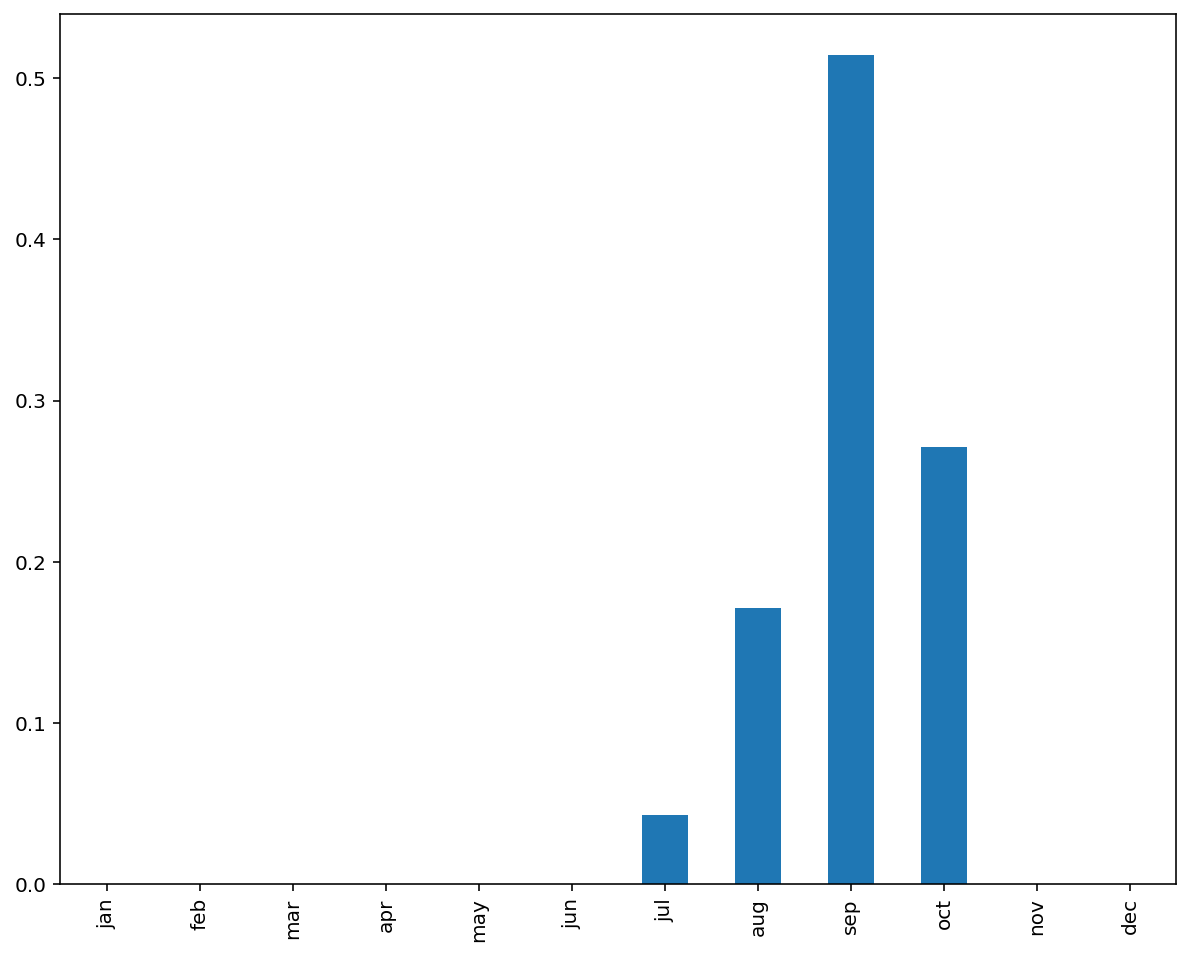

In [567]:
new_order = ['jan', 'feb', 'mar', 'apr', 'may','jun','jul','aug','sep','oct','nov','dec']
outages_clean[~outages_clean['hurricane.names'].isna()]['month'].value_counts(normalize=True).reindex(new_order).plot(kind='bar', figsize=(10,8));

From our visualization above, we see that outages resulting from hurricanes only occured in July, August, September, and October. As such, we have decided to classify those months as hurricane season, and the remaining months as non-hurricane season.

In [568]:
def binarize_hurricane_season(df):
    months = df.copy()['month']
    return months.apply(lambda month: (month=='jul') | 
                                      (month=='aug') | 
                                      (month=='sep') | 
                                      (month=='oct'))

Then we create a DataFrame containing all test outages, with their true cause categories, predicted cause categories, and whether or not they occurred in a hurricane month. This will help facillitate our analysis of fairness between hurricane season outages and non-hurricane season outages.

In [569]:
prediction_results = pd.DataFrame({'pred': grid_search.best_estimator_.predict(X_test),
                                   'true': y_test.to_numpy(),
                                    'hurricane_season': binarize_hurricane_season(X_test).to_numpy()})
prediction_results

,pred,true,hurricane_season
0,severe weather,severe weather,True
1,intentional attack,islanding,True
2,severe weather,severe weather,False
3,severe weather,severe weather,False
4,severe weather,severe weather,True
...,...,...,...
259,severe weather,severe weather,False
260,severe weather,equipment failure,True
261,severe weather,system operability disruption,False
262,severe weather,severe weather,True


To determine whether or not our classification model unfairly predicts hurricane season outage cause categories compared to non-hurricane season outage cause categories, we will be running a permutation test using the difference in prediction accuracy as a test statistic a significance level of 0.05. Since our prediction is relatively harmless, for example if we predicted that the cause was intentional attack when it really was public appeal there would not be horrifying consequences, we felt comfortable using a significance level of 0.05 as opposed to a tighter bound of 0.01.

> Null Hypothesis: Our model is fair. Its accuracy for hurricane season outages and non-hurricane season outages are roughly   
the same, and any differences are due to random chance.
<br>
<br>Alternative Hypothesis: Our model is unfair. Its accuracy for hurricane season outages is higher than its accuracy for non-hurricane season outages.


In [570]:
from sklearn.metrics import accuracy_score
def calc_acc(df):
    return accuracy_score(df['true'], df['pred'])

In [571]:
# TEST STAT: DIFFERENCE IN ACCURACY
obs = calc_acc(prediction_results[prediction_results['hurricane_season']]) - calc_acc(prediction_results[~prediction_results['hurricane_season']])
print("Observed Difference in Accuracy: " + str(obs))

Observed Difference in Accuracy: -0.0016172506738544312


In [584]:
stats = []
for _ in np.arange(1_000):
    prediction_results['hurricane_season'] = np.random.permutation(prediction_results['hurricane_season'])
    stats += [calc_acc(prediction_results[prediction_results['hurricane_season']]) - calc_acc(prediction_results[~prediction_results['hurricane_season']])]
p = (np.array(stats) >= obs).mean()
print("P-Value: " + str(p))

P-Value: 0.585


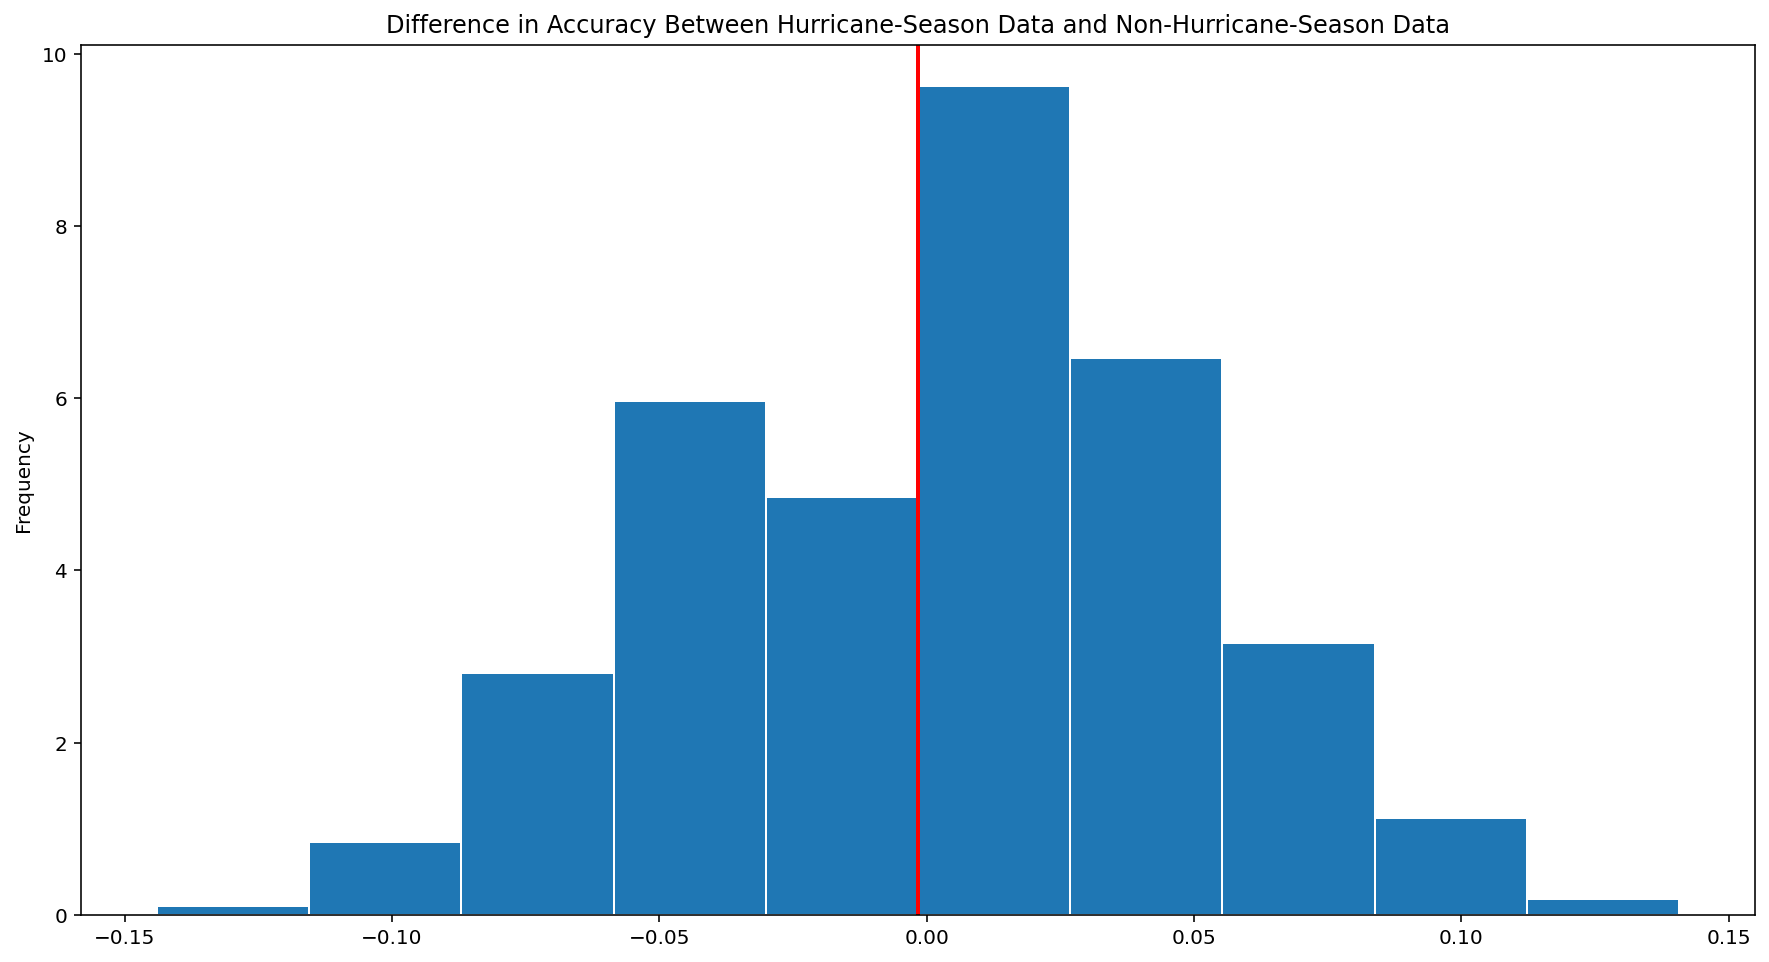

In [585]:
pd.Series(stats).plot(kind='hist', 
                     density=True,
                     ec='w',
                     title='Difference in Accuracy Between Hurricane-Season Data and Non-Hurricane-Season Data', 
                     figsize = (15,8));
plt.axvline(x=obs, color='red', linewidth=2);

As can be seen above, with a resulting p-value of 0.585, we fail to reject the null at a significance level of 0.05. It appears that our classification model performance is fair between outages that occured during hurricane season and non-hurricane season. This debunks our previous hypothesis in which our model would predict more accurately on hurricane season outages, due to the relatively large proportion of outages caused by hurricanes in those months.